## **[Real or Fake] Job Posting using Tensorflow**:

The idea of this project is to convert our previous implementation from scratch to a tensorflow 1 implementation. Here, we deal with the same Fake job posting dataset and implement firstly a single layer neural network and then extend it to a multi layer implementation. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import ops

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


In [ ]:
df = pd.read_csv('fake_job_postings.csv')

In [ ]:
df['country'] = df['location'].str.split(',', expand=True)[0]
df['state'] = df['location'].str.split(',', expand=True)[2]
df['city'] = df['location'].str.split(',', expand=True)[1]

In [ ]:
df['has_company_profile'] = df['company_profile'].isnull().astype(int)
df['has_salary_range'] = df['salary_range'].isnull().astype(int)
df['has_required_experience'] = df['required_experience'].isnull().astype(int)
df['has_required_education'] = df['required_education'].isnull().astype(int)

In [ ]:
df_sampled_0 = df[df['fraudulent']==0].sample(n = 866)
df_sampled = pd.concat([df_sampled_0, df[df['fraudulent']==1]]).sample(frac=1).reset_index(drop=True)
df_sampled.drop(['job_id', 'location', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits'], axis=1, inplace=True)
df_sampled.fillna('<None>', inplace=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
 

columns_to_encode =  ['title', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country', 'state', 'city']
ohe    = OneHotEncoder(sparse=False)
encoded_columns =    ohe.fit_transform(df_sampled[columns_to_encode])
encoded_df = pd.DataFrame(encoded_columns)
ohe.get_feature_names()
encoded_df.columns = ohe.get_feature_names()

In [ ]:
df_sampled_mod = df_sampled.drop(labels = columns_to_encode, axis=1)

In [ ]:
df_final = pd.concat([df_sampled_mod, encoded_df], axis=1)

In [ ]:
X = df_final.loc[:, df_final.columns != 'fraudulent']
y = df_final['fraudulent']

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [ ]:
X_train_flat = X_train.values.T
X_test_flat = X_test.values.T

In [ ]:
y_train_flat = y_train.values.reshape(1, -1)
y_test_flat = y_test.values.reshape(1, -1)

In [ ]:
X_train_flat.shape, y_train_flat.shape

((2494, 1212), (1, 1212))

### **Linear Regression using Tensorflow**

In [ ]:
x = tf.placeholder("float", shape = (X_train_flat.shape[0], None), name = 'x')
initializer = tf.initializers.glorot_uniform()
W = tf.Variable(initializer(shape = [1, X_train_flat.shape[0]]), name = 'W', dtype = "float32")
b = tf.zeros([1], name = 'b')
y = tf.placeholder("float", shape = [1, None])
Z = tf.matmul(W, x) + b
activation = tf.math.sigmoid(Z)
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z, labels = y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(cost)
prediction = tf.round(activation)
correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iteration: 0 cost= 0.68317145 training accuracy= 0.5750825 test accuracy =  0.58076924
Iteration: 500 cost= 0.3722579 training accuracy= 0.8547855 test accuracy =  0.8403846
Iteration: 1000 cost= 0.3278583 training accuracy= 0.8828383 test accuracy =  0.84615386
Iteration: 1500 cost= 0.2997002 training accuracy= 0.8894389 test accuracy =  0.85384613
Iteration: 2000 cost= 0.27835396 training accuracy= 0.8968647 test accuracy =  0.8576923
Iteration: 2500 cost= 0.26101398 training accuracy= 0.910066 test accuracy =  0.86346155
Training phase finished


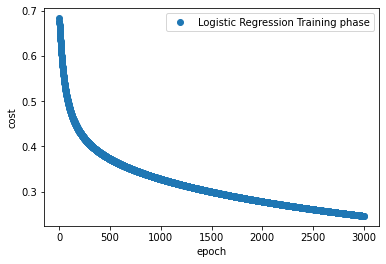

In [ ]:
train_acc = []
test_acc = []

init = tf.initialize_all_variables()
with tf.Session() as sess:
  sess.run(init)
  iteration = []
  x_entropy = []
  for i in range(3000):
    avg_cost = 0
    sess.run(optimizer, feed_dict = {x: X_train_flat, y:y_train_flat})
    avg_cost = sess.run(cost, feed_dict = {x: X_train_flat, y:y_train_flat})
    temp_train_acc = sess.run(accuracy, feed_dict={x: X_train_flat, y: y_train_flat})
    temp_test_acc = sess.run(accuracy, feed_dict={x: X_test_flat, y: y_test_flat})
    if i % 500 == 0:
      print("Iteration:", i, "cost=", avg_cost, "training accuracy=", temp_train_acc, "test accuracy = ", temp_test_acc)
    x_entropy.append(avg_cost)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    iteration.append(i)
    
  print ("Training phase finished")
  plt.plot(iteration, x_entropy, 'o', label='Logistic Regression Training phase')
  plt.ylabel('cost')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

Here, as you can see, we used Adam optimizer and got a training accuracy of 91% and test accuracy of 86% which is not bad considering only one sigmoid layer.

### **Deep Learning using Tensorflow**

Now for multi layer implementation, in the following example we consider three layers. The first layer is the input layer, and all the layers except for the final layer has relu as activation. The final layer is sigmoid.

In [ ]:
layers_dims = [X_train_flat.shape[0], 5, 1]

In [ ]:
def initialize_deep():
  parameters = {}
  initializer1 = tf.initializers.glorot_uniform()
  initializer2 = tf.compat.v1.zeros_initializer()
  
  L = len(layers_dims)
  for i in range(L-1):
    W = tf.Variable(initializer1(shape = [layers_dims[i+1], layers_dims[i]]), name = 'W' + str(i+1), dtype = "float32")
    b = tf.Variable(initializer2(shape = [layers_dims[i+1], 1]), name = 'b' + str(i+1), dtype = "float32")
    parameters['W' + str(i+1)] = W
    parameters['b' + str(i+1)] = b
  return parameters

In [ ]:
def forward_propagation(A, parameters):
  L = len(layers_dims)
  for i in range(L-2):
    W = parameters['W' + str(i+1)]
    b = parameters['b' + str(i+1)]
    A = tf.nn.relu(tf.matmul(W, A) + b)

  WL = parameters['W' + str(L-1)]
  bL = parameters['b' + str(L-1)]
  ZL = tf.matmul(WL, A) + bL
  return ZL

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001):
  ops.reset_default_graph()
  X = tf.placeholder("float", shape = (X_train_flat.shape[0], None), name = 'X')
  y = tf.placeholder("float", shape = [1, None], name = 'y')
  parameters = initialize_deep()
  ZL = forward_propagation(X, parameters)
  cost = cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = ZL, labels = y))
  activation = tf.math.sigmoid(ZL)
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  prediction = tf.round(activation)
  correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
  accuracy = tf.reduce_mean(correct)

  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    x_entropy = []
    for i in range(3000):
      avg_cost = 0
      _, avg_cost = sess.run([optimizer, cost], feed_dict = {X: X_train_flat, y:y_train_flat})
      x_entropy.append(avg_cost)
      temp_train_acc = sess.run(accuracy, feed_dict={X: X_train_flat, y: y_train_flat})
      temp_test_acc = sess.run(accuracy, feed_dict={X: X_test_flat, y: y_test_flat})
      if i % 100 == 0:
        print("Iteration:", i, "cost=", avg_cost, "training accuracy=", temp_train_acc, "test accuracy =", temp_test_acc)
  return

In [ ]:
parameters = model(X_train_flat, y_train_flat, X_test_flat, y_test_flat, learning_rate = 0.0001)


Iteration: 0 cost= 0.69110125 training accuracy= 0.56848186 test accuracy = 0.5692308
Iteration: 100 cost= 0.6577348 training accuracy= 0.8506601 test accuracy = 0.7865385
Iteration: 200 cost= 0.61750746 training accuracy= 0.9232673 test accuracy = 0.84807694
Iteration: 300 cost= 0.57833344 training accuracy= 0.93976897 test accuracy = 0.8576923
Iteration: 400 cost= 0.5405294 training accuracy= 0.9447195 test accuracy = 0.86346155
Iteration: 500 cost= 0.5040674 training accuracy= 0.95049506 test accuracy = 0.86346155
Iteration: 600 cost= 0.46917492 training accuracy= 0.9554455 test accuracy = 0.86730766
Iteration: 700 cost= 0.43613964 training accuracy= 0.9612211 test accuracy = 0.86730766
Iteration: 800 cost= 0.40514606 training accuracy= 0.9669967 test accuracy = 0.86346155
Iteration: 900 cost= 0.3762211 training accuracy= 0.9686469 test accuracy = 0.86538464
Iteration: 1000 cost= 0.34933287 training accuracy= 0.9711221 test accuracy = 0.86538464
Iteration: 1100 cost= 0.32447585 trai

With this simple implementation, we have 99% training accuracy and 87% test accuracy. This shows the prevalance of large variance which we will try to reduce with some regularizers.

## **Regularizations:**

### **Dropout:**

Like in the previous project, here we perform dropout regularization. 

In [ ]:
def forward_propagation_dropout(A, parameters, keep_prob):
  L = len(layers_dims)
  for i in range(L-2):
    W = parameters['W' + str(i+1)]
    b = parameters['b' + str(i+1)]
    A = tf.nn.dropout(A, rate = 1-keep_prob[i])
    A = tf.nn.relu(tf.matmul(W, A) + b)

  WL = parameters['W' + str(L-1)]
  bL = parameters['b' + str(L-1)]
  A = tf.nn.dropout(A, rate = 1-keep_prob[L-1])
  ZL = tf.matmul(WL, A) + bL
  return ZL

In [ ]:
def model_dropout(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001):
  ops.reset_default_graph()
  X = tf.placeholder("float", shape = (X_train_flat.shape[0], None), name = 'X')
  y = tf.placeholder("float", shape = [1, None], name = 'y')
  keep_prob = tf.placeholder("float", shape = [3], name = 'keep_prob')
  parameters = initialize_deep()
  ZL = forward_propagation_dropout(X, parameters, keep_prob)
  cost = cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = ZL, labels = y))
  activation = tf.math.sigmoid(ZL)
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  prediction = tf.round(activation)
  correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
  accuracy = tf.reduce_mean(correct)

  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    x_entropy = []
    for i in range(4000):
      avg_cost = 0
      _, avg_cost = sess.run([optimizer, cost], feed_dict = {X: X_train_flat, y:y_train_flat, keep_prob:[.5, .5, 1]})
      x_entropy.append(avg_cost)
      temp_train_acc = sess.run(accuracy, feed_dict={X: X_train_flat, y: y_train_flat, keep_prob:[.5, .5, 1]})
      temp_test_acc = sess.run(accuracy, feed_dict={X: X_test_flat, y: y_test_flat, keep_prob:[1, 1, 1]})
      if i % 100 == 0:
        print("Iteration:", i, "cost=", avg_cost, "training accuracy=", temp_train_acc, "test accuracy =", temp_test_acc)
  return

In [ ]:
parameters = model_dropout(X_train_flat, y_train_flat, X_test_flat, y_test_flat, learning_rate = 0.01)

Iteration: 0 cost= 0.6998343 training accuracy= 0.6460396 test accuracy = 0.7019231
Iteration: 100 cost= 0.13782416 training accuracy= 0.9249175 test accuracy = 0.86923075
Iteration: 200 cost= 0.13731122 training accuracy= 0.9414191 test accuracy = 0.87884617
Iteration: 300 cost= 0.14313164 training accuracy= 0.929868 test accuracy = 0.875
Iteration: 400 cost= 0.15237069 training accuracy= 0.9480198 test accuracy = 0.8730769
Iteration: 500 cost= 0.121123195 training accuracy= 0.9430693 test accuracy = 0.88653845
Iteration: 600 cost= 0.1218443 training accuracy= 0.94966996 test accuracy = 0.88461536
Iteration: 700 cost= 0.12154193 training accuracy= 0.9480198 test accuracy = 0.88461536
Iteration: 800 cost= 0.09585942 training accuracy= 0.94966996 test accuracy = 0.88076925
Iteration: 900 cost= 0.10624713 training accuracy= 0.9447195 test accuracy = 0.88269234
Iteration: 1000 cost= 0.116999745 training accuracy= 0.9537954 test accuracy = 0.87884617
Iteration: 1100 cost= 0.10973575 traini

After dropout, the gap between training and test accuracy has decreased. The This is a good result as it means that the overfitting problem is reduced.

### L2:

After dropout, not let us implement the L2 regularization. The main change here is when we compute the cost, as now in the cost function, we also need to minimize the sum of Frobenius norm of the weight matrices for each layer.

In [ ]:
beta = 0.01
def model_L2(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001):
  ops.reset_default_graph()
  X = tf.placeholder("float", shape = (X_train_flat.shape[0], None), name = 'X')
  y = tf.placeholder("float", shape = [1, None], name = 'y')
  parameters = initialize_deep()
  ZL = forward_propagation(X, parameters)
  cost = cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = ZL, labels = y))
  regularizer = 0
  for i in range(len(layers_dims)-2):
    regularizer+= tf.nn.l2_loss(parameters['W'+str(i+1)])
  cost = tf.reduce_mean(cost + beta * regularizer)

  activation = tf.math.sigmoid(ZL)
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  prediction = tf.round(activation)
  correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
  accuracy = tf.reduce_mean(correct)

  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    x_entropy = []
    for i in range(3000):
      avg_cost = 0
      _, avg_cost = sess.run([optimizer, cost], feed_dict = {X: X_train_flat, y:y_train_flat})
      x_entropy.append(avg_cost)
      temp_train_acc = sess.run(accuracy, feed_dict={X: X_train_flat, y: y_train_flat})
      temp_test_acc = sess.run(accuracy, feed_dict={X: X_test_flat, y: y_test_flat})
      if i % 100 == 0:
        print("Iteration:", i, "cost=", avg_cost, "training accuracy=", temp_train_acc, "test accuracy =", temp_test_acc)
  return

In [ ]:
parameters = model_L2(X_train_flat, y_train_flat, X_test_flat, y_test_flat, learning_rate = 0.01)

Iteration: 0 cost= 0.74208575 training accuracy= 0.7714521 test accuracy = 0.72692305
Iteration: 100 cost= 0.24779354 training accuracy= 0.9579208 test accuracy = 0.8923077
Iteration: 200 cost= 0.19267541 training accuracy= 0.9818482 test accuracy = 0.9096154
Iteration: 300 cost= 0.15883157 training accuracy= 0.9925743 test accuracy = 0.9096154
Iteration: 400 cost= 0.13607498 training accuracy= 0.9950495 test accuracy = 0.9096154
Iteration: 500 cost= 0.11985906 training accuracy= 0.99834985 test accuracy = 0.9076923
Iteration: 600 cost= 0.10725707 training accuracy= 1.0 test accuracy = 0.9096154
Iteration: 700 cost= 0.09743647 training accuracy= 1.0 test accuracy = 0.9096154
Iteration: 800 cost= 0.08991629 training accuracy= 1.0 test accuracy = 0.91346157
Iteration: 900 cost= 0.08284359 training accuracy= 1.0 test accuracy = 0.9115385
Iteration: 1000 cost= 0.077466115 training accuracy= 1.0 test accuracy = 0.9076923
Iteration: 1100 cost= 0.07285159 training accuracy= 1.0 test accuracy 

This reguaization has increased the test accuracy to 90%.

### **L2 + Dropout:**

Now finally, let us add the two regulaizations together.

In [ ]:
def model_regularization(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001):
  ops.reset_default_graph()
  X = tf.placeholder("float", shape = (X_train_flat.shape[0], None), name = 'X')
  y = tf.placeholder("float", shape = [1, None], name = 'y')
  keep_prob = tf.placeholder("float", shape = [3], name = 'keep_prob')
  parameters = initialize_deep()
  ZL = forward_propagation_dropout(X, parameters, keep_prob)
  cost = cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = ZL, labels = y))
  regularizer = 0
  for i in range(len(layers_dims)-2):
    regularizer+= tf.nn.l2_loss(parameters['W'+str(i+1)])
  cost = tf.reduce_mean(cost + beta * regularizer)

  activation = tf.math.sigmoid(ZL)
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  prediction = tf.round(activation)
  correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
  accuracy = tf.reduce_mean(correct)

  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    x_entropy = []
    for i in range(4000):
      avg_cost = 0
      _, avg_cost = sess.run([optimizer, cost], feed_dict = {X: X_train_flat, y:y_train_flat, keep_prob:[.5, .5, 1]})
      x_entropy.append(avg_cost)
      temp_train_acc = sess.run(accuracy, feed_dict={X: X_train_flat, y: y_train_flat, keep_prob:[.5, .5, 1]})
      temp_test_acc = sess.run(accuracy, feed_dict={X: X_test_flat, y: y_test_flat, keep_prob:[1, 1, 1]})
      if i % 100 == 0:
        print("Iteration:", i, "cost=", avg_cost, "training accuracy=", temp_train_acc, "test accuracy =", temp_test_acc)
  return

In [ ]:
parameters = model_regularization(X_train_flat, y_train_flat, X_test_flat, y_test_flat, learning_rate = 0.01)

Iteration: 0 cost= 0.749731 training accuracy= 0.57838285 test accuracy = 0.6403846
Iteration: 100 cost= 0.42012957 training accuracy= 0.85231024 test accuracy = 0.8769231
Iteration: 200 cost= 0.35636252 training accuracy= 0.8927393 test accuracy = 0.8769231
Iteration: 300 cost= 0.348603 training accuracy= 0.9026403 test accuracy = 0.8903846
Iteration: 400 cost= 0.3263884 training accuracy= 0.9158416 test accuracy = 0.875
Iteration: 500 cost= 0.30300987 training accuracy= 0.900165 test accuracy = 0.8769231
Iteration: 600 cost= 0.2968905 training accuracy= 0.9141914 test accuracy = 0.88461536
Iteration: 700 cost= 0.2861185 training accuracy= 0.9092409 test accuracy = 0.88653845
Iteration: 800 cost= 0.27241087 training accuracy= 0.9232673 test accuracy = 0.875
Iteration: 900 cost= 0.2679056 training accuracy= 0.90841585 test accuracy = 0.875
Iteration: 1000 cost= 0.26479322 training accuracy= 0.9240924 test accuracy = 0.88653845
Iteration: 1100 cost= 0.24837644 training accuracy= 0.92409

With this implementation, the problem of overfitting has reduced significantly. In order to increase the bias in the data, we need to better model the features, maybe use natural langauge processing methods.